In [286]:
# here I took real data from kepler Objects of Interest -> https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data  = pd.read_csv(r"C:\Users\opera\OneDrive\Documentos\GitHub\EXXAtest\sequetialTest\cumulative_2025.04.06_21.03.06.csv")

# Filtrar exoplanetas confirmados y falsos positivos
exoplanets = data[data['koi_disposition'] == 'CONFIRMED']
falsos_positivos = data[data['koi_disposition'] == 'FALSE POSITIVE']

# Tomar 500 muestras de cada grupo
exoplanets_sample = exoplanets.sample(n=500, random_state=42)
falsos_positivos_sample = falsos_positivos.sample(n=500, random_state=42)

# Concatenar ambos para balancear
balanced = pd.concat([exoplanets_sample, falsos_positivos_sample])

# Seleccionar solo las columnas deseadas (sin 'label')
balanced = balanced[['koi_prad', 'koi_srad']]


# # find k
balanced.dropna(inplace=True) 
balanced['K'] = (balanced['koi_prad'] / balanced['koi_srad']) ** 2
balanced = balanced.drop(columns=['koi_prad', 'koi_srad'])
balanced.to_csv('dataset_exoplanetas_con_k.csv', index=False)
# print(data_balanceado[data_balanceado["K"] < 1.0]["K"])
# print(data_balanceado[data_balanceado["K"] >= 1.0]["K"])
# add the column 'label' k condition
# if K < 1.0 => label = 0 (exoplanet)
# Si K >= 1.0 => label = 1 (no exoplanet)
balanced['label'] = np.where(balanced['K'] < 1.0, 0, 1)

# reduce the number of samples to 250 for label 1 class
negative = balanced[balanced["label"] == 1].sample(n=250, random_state=42)
positive = balanced[balanced["label"] == 0]

balanced = pd.concat([positive, negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# verify the data
print(balanced[balanced["label"] == 1].count())
print(balanced[balanced["label"] == 0].count())


k = list(balanced["K"].values.flatten())
label = list(balanced["label"].values.flatten())
len(k), len(label)

K        250
label    250
dtype: int64
K        114
label    114
dtype: int64


(364, 364)

<!-- # It’s important to note that this threshold (K > 1.0) is **not physically accurate** for classifying exoplanets.
# In reality, planets usually have K values much smaller than 1 (typically K < 0.2),
# because planetary radii are much smaller than stellar radii.
# A K > 1.0 implies an object larger than the star itself, which is unrealistic for an exoplanet and
# would more likely represent an eclipsing binary or a misclassification.
#
# However, this filtering is necessary in this context because under the modeling constraints,
# the resulting transit light curves with K > 1.0 do not exhibit realistic or detectable transit features,
# which may confuse the model or downstream classification.
# This makes the filtering a practical decision to ensure data consistency and valid transit shapes. -->

In [339]:
import numpy as np
from pytransit import QuadraticModel

k_list = k            
y_list = label      

# constraints
ldc = [0.6, 0.5]
a = 4.2
i = 0.5 * np.pi
p = 1.0  
t0 = 0.0
noise_std = 0.005
# transit model
tm = QuadraticModel()
tm.set_data(np.linspace(-0.05, 0.05, 200))  # time negative because we have to center the transit in 0.0

# generate the dataset
X = []

for k_val in k_list:
    flux = tm.evaluate(k=k_val, ldc=ldc, t0=t0, p=p, a=a, i=i, e=0.0, w=0.0)
    noise = np.random.normal(loc=0.0, scale=noise_std, size=flux.shape)
    flux_noisy = flux + noise
    X.append(flux_noisy)

X = np.array(X)             
y = np.array(y_list)     

In [329]:
print(X.shape)  
print(y.shape) 

(364, 200)
(364,)


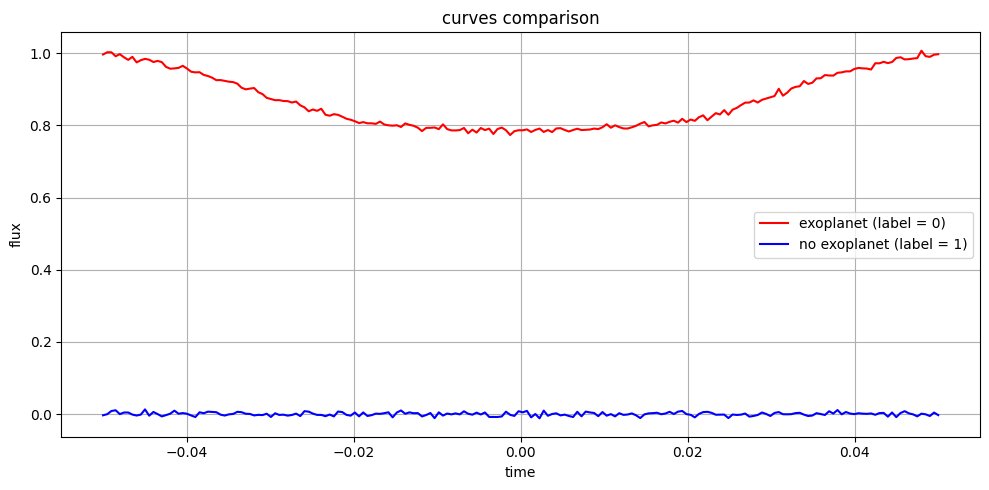

In [330]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Encontrar índices para cada clase
idxs_no_planet = [i for i, lbl in enumerate(y) if lbl == 0]
idxs_planet = [i for i, lbl in enumerate(y) if lbl == 1]

# Seleccionar uno aleatorio de cada clase
idx_no_planet = random.choice(idxs_no_planet)
idx_planet = random.choice(idxs_planet)

# Graficar
plt.figure(figsize=(10, 5))

plt.plot(tm.time, X[idx_no_planet], label="exoplanet (label = 0)", color='red')
plt.plot(tm.time, X[idx_planet], label="no exoplanet (label = 1)", color='blue')

plt.xlabel("time")
plt.ylabel("flux")
plt.title("curves comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# 4. ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

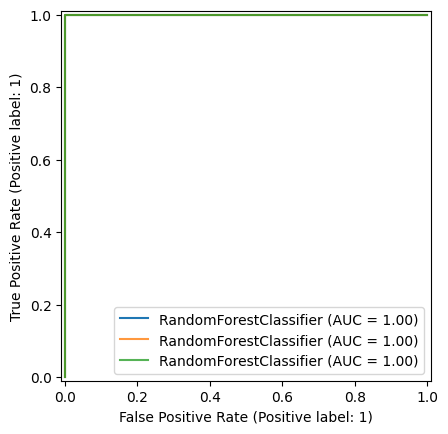

In [333]:
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
svc_disp = RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

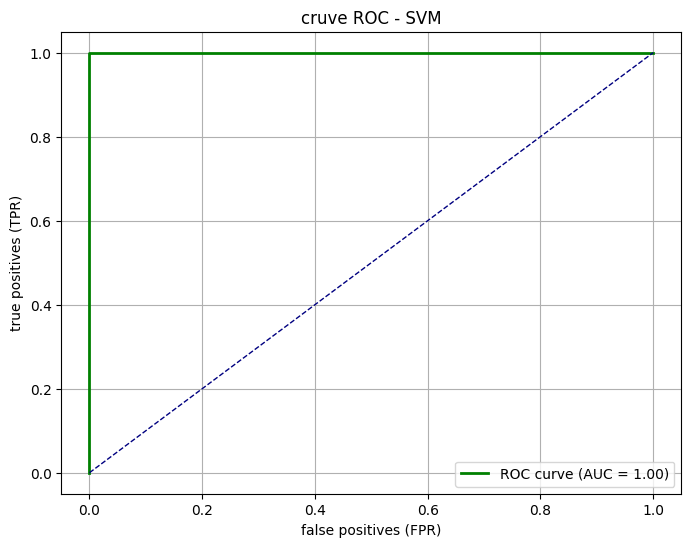

In [334]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('false positives (FPR)')
plt.ylabel('true positives (TPR)')
plt.title('cruve ROC - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

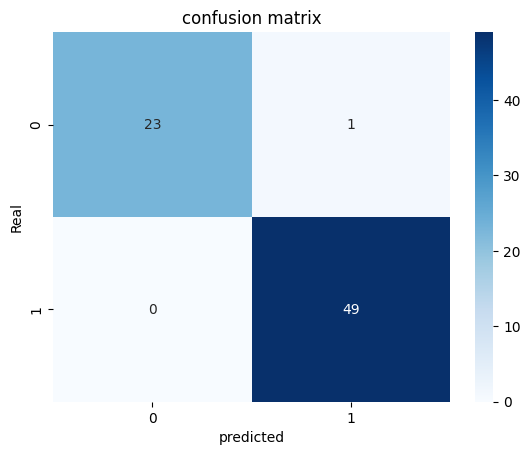

In [335]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('Real')
plt.title('confusion matrix')
plt.show()

In [336]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print("AUC promedio (5-fold CV):", np.mean(scores))

AUC promedio (5-fold CV): 1.0


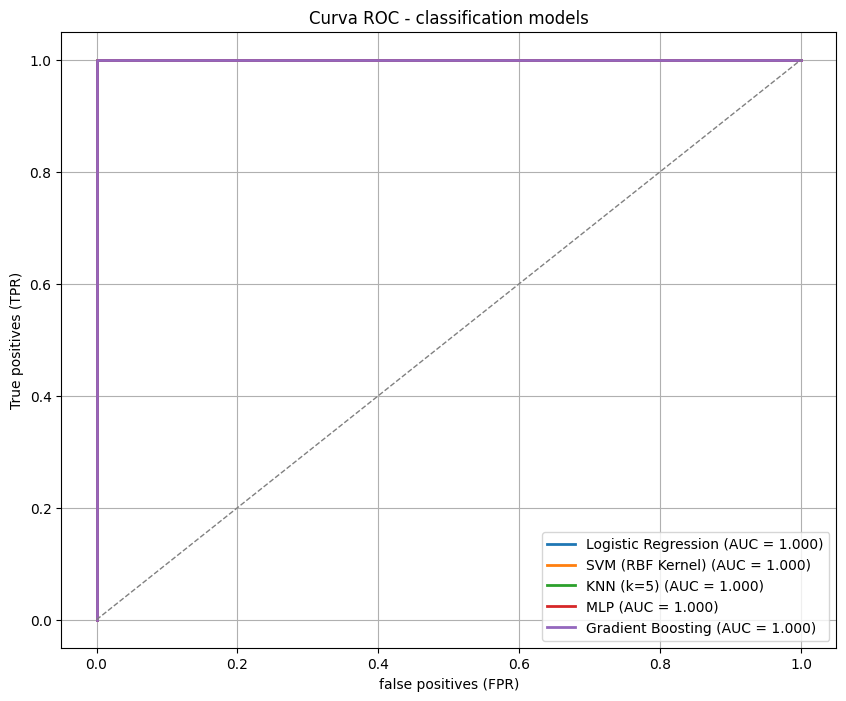

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(probability=True),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier()
}

plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('false positives (FPR)')
plt.ylabel('True positives (TPR)')
plt.title('Curva ROC - classification models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()